Investigate the glacier-sclae and regional-scale trend in dhdt etc...

In [45]:
import os
import rasterio as rio
import numpy as np
import shapely 
import pyproj
import geopandas as gpd
import matplotlib.pyplot as plt
import rioxarray as riox
import rasterio as rio
import xarray as xr
import netCDF4
from osgeo import gdal
import pandas as pd
from datetime import datetime
import dask.array
import matplotlib as mpl
import matplotlib.ticker as mticker
from sklearn import linear_model
from sklearn.feature_selection import f_regression
import cartopy.crs as ccrs
import cartopy as ctp

In [34]:
# define folder and file paths
folder_HMA = os.path.join('C:',os.sep,'Users','lzell','OneDrive - Colostate','Desktop',"HMA2")
folder_glaciers = os.path.join(folder_HMA, 'Glacier Products')
folder_datasets = os.path.join(folder_HMA, 'Datasets')
folder_plotting = os.path.join(folder_HMA, 'Plotting')
fp_rgi = os.path.join(folder_HMA, 'Datasets', 'AOI definition', 'Final AOI', "Final Products", 'AOI_full_rgi.shp')
fp_dc = os.path.join(folder_HMA, 'Datasets', 'AOI definition', 'Final AOI', "Final Products", 'AOI_dc_rgi.shp')
fp_regions = os.path.join(folder_HMA, 'Datasets', 'AOI definition', 'Final AOI', "Final Products", 'subregion_boundaries.shp')

In [3]:
# open the rgi gdf, regions gdf
rgi_gdf = gpd.read_file(fp_rgi).to_crs("ESRI:102025")
dc_gdf = gpd.read_file(fp_dc).to_crs("ESRI:102025")
regions_gdf = gpd.read_file(fp_regions).to_crs("ESRI:102025")

# add the o3region as a column to each rgi
regions_gdf = regions_gdf.rename({"id":"o3region"}, axis=1)
rgi_gdf = rgi_gdf.sjoin(regions_gdf[["o3region","geometry"]])
dc_gdf = dc_gdf.sjoin(regions_gdf[["o3region","geometry"]])

In [36]:
# other matplotlib stuff
mpl.rcParams['font.family'] = 'Arial'
mpl.rcParams['mathtext.fontset'] = 'custom'
mpl.rcParams['mathtext.rm'] = 'Arial'

In [4]:
# open the base data for each glacier, format into a single df
# debris cover, length, elevation, etc...
c=0
all_series = []
for idx, row in rgi_gdf.iterrows():
    c+=1
    # if c>10: continue
    
    rgi_id = row['rgi_id']
    o1region = row['o1region']
    o2region = row['o2region']
    o3region = row['o3region']
    
    # if o1region!='15':continue
    # print progress
    # print(c, "of", len(rgi_gdf), rgi_id)
    if c%100==0: print(c, "of", len(rgi_gdf), rgi_id)

    # open glacier-specific cloud info as a pd.Series, append to list
    path_open = os.path.join(folder_glaciers, rgi_id, 'Base Products', 'base_info.csv')
    df_g = pd.read_csv(path_open, index_col=0, header=None).squeeze()
    df_g['o3_region'] = str(o3region)
    all_series.append(df_g)

# format into df
df_all = pd.DataFrame(all_series).reset_index(drop=True)


# format to numeric dtypes
all_cols = df_all.columns
for c in all_cols:
    if c in ['rgi_id', 'o1_region', 'o2_region']: continue
    df_all[c] = df_all[c].astype(float)

# merge with glacier area
print("All done!")

100 of 769 RGI2000-v7.0-G-14-06944
200 of 769 RGI2000-v7.0-G-13-71307
300 of 769 RGI2000-v7.0-G-14-15108
400 of 769 RGI2000-v7.0-G-14-32564
500 of 769 RGI2000-v7.0-G-15-01330
600 of 769 RGI2000-v7.0-G-15-05352
700 of 769 RGI2000-v7.0-G-15-08609
All done!


In [5]:
# open the trends is sgl area, temp, and precip
path_open = os.path.join(folder_datasets,'glacier_sgl_trends.csv')
df_sgl_trends = pd.read_csv(path_open)

path_open = os.path.join(folder_datasets,'glacier_temp_trends.csv')
df_temp_trends = pd.read_csv(path_open)

path_open = os.path.join(folder_datasets,'glacier_prec_trends.csv')
df_prec_trends = pd.read_csv(path_open)

In [18]:
# identify glaciers that are increasing, decreasing, or staying constant in sgl area
print("total glaciers:", len(df_sgl_trends))

# first subset to rows that have median sgl area greater than xyz
df_substantial = df_sgl_trends[ (df_sgl_trends['median']>4500) ]
print("substantial glaciers:", len(df_substantial))

# then subset to those that are significantly increasing, decreasing, or not changing
df_significant = df_substantial[(df_substantial['p']<=0.05) & (df_substantial['p']>0.05)]

df_nochange = df_substantial[ (df_substantial['p']>0.05) ]
df_increase = df_substantial[ (df_substantial['p']<=0.05) & (df_substantial['slope']>0)]
df_decrease = df_substantial[ (df_substantial['p']<=0.05) & (df_substantial['slope']<0)]

# also look at glaciers that are large but don't have significant sgls
df_no_sgl = df_sgl_trends[ (df_sgl_trends['median']<4500) & (df_sgl_trends['area_dc']>2) ]

rgi_increase = df_increase['rgi_id']
rgi_decrease = df_decrease['rgi_id']
rgi_nochange = df_nochange['rgi_id']
rgi_nolakes = df_no_sgl['rgi_id']

print("constant glaciers:", len(df_nochange), 
      "\nincreasing glaciers:", len(df_increase), 
      "\ndecreasing glaciers:", len(df_decrease),
      "\nno-lake glaciers:", len(df_no_sgl))

total glaciers: 750
substantial glaciers: 169
constant glaciers: 76 
increasing glaciers: 80 
decreasing glaciers: 13 
no-lake glaciers: 178


In [19]:
df_meta_nochange = df_all[df_all['rgi_id'].isin(rgi_nochange)]
df_meta_increase = df_all[df_all['rgi_id'].isin(rgi_increase)]
df_meta_decrease = df_all[df_all['rgi_id'].isin(rgi_decrease)]
df_meta_nolakes = df_all[df_all['rgi_id'].isin(rgi_nolakes)]

In [42]:
# map showing locations of each of these

# opening a Natural Earth background
path_background = os.path.join(folder_plotting, 'NE1_HR_LC', "NE1_HR_LC_projected.tif")
background_im = riox.open_rasterio(path_background)

# clip to main extent
xlims = (-2500000, 1000000)
ylims = (-700000, 2000000)
background_im = background_im.sel(x=slice(xlims[0]-2000,xlims[1]+2000), y=slice(ylims[1]+2000, ylims[0]-2000))

# open the subregion df
path_o1 = os.path.join(folder_HMA, 'Datasets', "RGI", "RGI2000-v7.0-regions", "RGI2000-v7.0-o1regions.shp")
path_o2 = os.path.join(folder_HMA, 'Datasets', "RGI", "RGI2000-v7.0-regions", "RGI2000-v7.0-o2regions.shp")
o1_gdf = gpd.read_file(path_o1).to_crs("ESRI:102025")
o2_gdf_all = gpd.read_file(path_o2).to_crs("ESRI:102025")

# subset to the HMA regions
o1_gdf = o1_gdf[o1_gdf['o1region'].isin(["13","14","15"])]
o2_gdf = o2_gdf_all[o2_gdf_all['o2region'].isin(rgi_gdf['o2region'])].copy() # only get o2regions with our glaciers

# add color column to o2_gdf, based on o1region
colors = []
for idx,row in o2_gdf.iterrows():
    if row['o1region']=='13': colors.append('red')
    elif row['o1region']=='14': colors.append('blue')
    elif row['o1region']=='15': colors.append('yellow')
o2_gdf['colors']=colors

# define esri:102025 projection for cartopy
projection = ccrs.AlbersEqualArea(central_longitude=95.0, central_latitude=30,
                            false_easting=0.0, false_northing=0.0,
                            standard_parallels=(15.0, 65.0), globe=None)

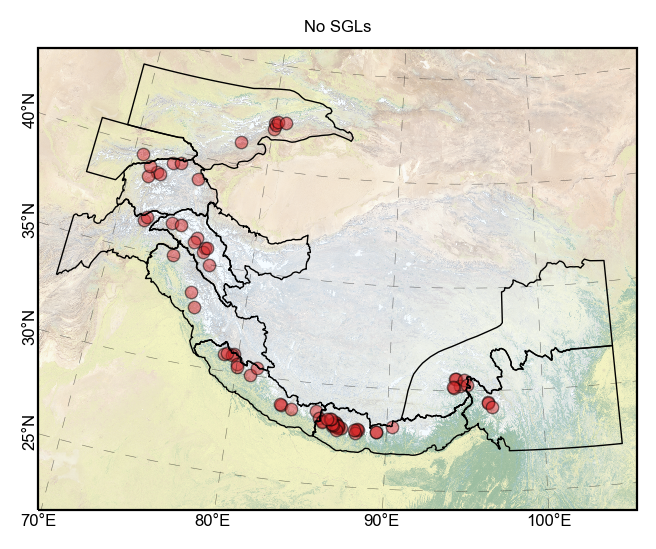

In [105]:
# initiate figure
fig,axs = plt.subplots(figsize=(4,3), dpi=200, subplot_kw={'projection': projection})

# background image
background_im.plot.imshow(rgb='band', ax=axs)

# o2region boundaries, adding colors along the way
o2_gdf.boundary.plot(ax=axs, edgecolor='black', facecolor='none', linewidth=0.5)
# o2_gdf.plot(ax=axs, edgecolor='none', color=o2_gdf['colors'], alpha=0.2)
# o1_gdf.plot(ax=axs, edgecolor='black', facecolor='none')



# add glaicers with incresing sgls
rgi_plot = rgi_gdf[rgi_gdf['rgi_id'].isin(rgi_increase)]
gdf_points = gpd.GeoDataFrame({}, geometry=gpd.points_from_xy(rgi_plot['cenlon'],rgi_plot['cenlat']),crs="EPSG:4326").to_crs("ESRI:102025")
gdf_points.plot(ax=axs, color='tab:red', edgecolor='black', markersize=20, linewidth=0.5, alpha=0.5)

# # add glaciers with decreasing sgls
# rgi_plot = rgi_gdf[rgi_gdf['rgi_id'].isin(rgi_decrease)]
# gdf_points = gpd.GeoDataFrame({}, geometry=gpd.points_from_xy(rgi_plot['cenlon'],rgi_plot['cenlat']),crs="EPSG:4326").to_crs("ESRI:102025")
# gdf_points.plot(ax=axs, color='blue', edgecolor='black', markersize=20, linewidth=0.5, alpha=0.5)

# add glaciers with no change, but substantial sgls
# rgi_plot = rgi_gdf[rgi_gdf['rgi_id'].isin(rgi_nochange)]
# gdf_points = gpd.GeoDataFrame({}, geometry=gpd.points_from_xy(rgi_plot['cenlon'],rgi_plot['cenlat']),crs="EPSG:4326").to_crs("ESRI:102025")
# gdf_points.plot(ax=axs, color='gold', edgecolor='black', markersize=20, linewidth=0.5, alpha=0.5)

# add glaciers with no SGLs
# rgi_plot = rgi_gdf[rgi_gdf['rgi_id'].isin(rgi_nolakes)]
# gdf_points = gpd.GeoDataFrame({}, geometry=gpd.points_from_xy(rgi_plot['cenlon'],rgi_plot['cenlat']),crs="EPSG:4326").to_crs("ESRI:102025")
# gdf_points.plot(ax=axs, color='purple', edgecolor='black', markersize=20, linewidth=0.5, alpha=0.5)



# axis limits, etc
axs.set_xlim(xlims)
axs.set_ylim(ylims)
axs.set_title("No SGLs", size=6)

# add lat/lon gridlines
gl = axs.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, ypadding=3, xpadding=4,
              linestyle=(5,(20,20)), linewidth=0.2, color='0', alpha=0.5)

# gridline edits
gl.top_labels=False
gl.right_labels=False
gl.xlabel_style = {'size':6, 'rotation':'horizontal', 'ha':'center'}
gl.ylabel_style = {'size':6, 'rotation':'vertical', 'ha':'center'}
gl.xlocator = mticker.FixedLocator([70, 80, 90, 100])
gl.ylocator = mticker.FixedLocator([25, 30, 35, 40, 45])

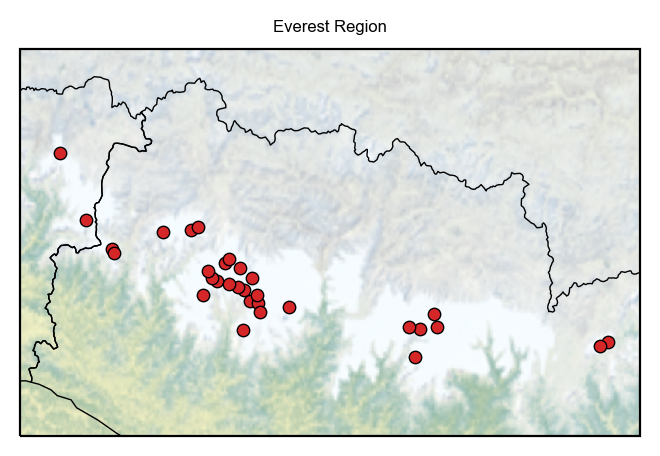

In [123]:
# zoom in on eastern nepal


# initiate figure
fig,axs = plt.subplots(figsize=(4,3), dpi=200, subplot_kw={'projection': projection})

# background image
background_im.plot.imshow(rgb='band', ax=axs)

# o2region boundaries, adding colors along the way
o2_gdf.boundary.plot(ax=axs, edgecolor='black', facecolor='none', linewidth=0.5)

# add glaicers with incresing sgls
rgi_plot = rgi_gdf[rgi_gdf['rgi_id'].isin(rgi_increase)]
gdf_points = gpd.GeoDataFrame({}, geometry=gpd.points_from_xy(rgi_plot['cenlon'],rgi_plot['cenlat']),crs="EPSG:4326").to_crs("ESRI:102025")
gdf_points.plot(ax=axs, color='tab:red', edgecolor='black', markersize=20, linewidth=0.5, alpha=1)

xlims = (-900000, -500000)
ylims = (-300000, -50000)

# axis limits, etc
axs.set_xlim(xlims)
axs.set_ylim(ylims)
axs.set_title("Everest Region", size=6)

# add lat/lon gridlines
gl = axs.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, ypadding=3, xpadding=4,
              linestyle=(5,(20,20)), linewidth=0.2, color='0', alpha=0.5)

# gridline edits
gl.top_labels=False
gl.right_labels=False
gl.xlabel_style = {'size':6, 'rotation':'horizontal', 'ha':'center'}
gl.ylabel_style = {'size':6, 'rotation':'vertical', 'ha':'center'}
gl.xlocator = mticker.FixedLocator([70, 80, 90, 100])
gl.ylocator = mticker.FixedLocator([25, 30, 35, 40, 45])

In [20]:
df_meta_increase.columns

Index(['rgi_id', 'o1_region', 'o2_region', 'area_km2', 'dc_area_km2',
       'dc_length', 'z_mean', 'z_med', 'z_min', 'z_max', 'z_25', 'z_75',
       'v_mean', 'v_med', 'v_min', 'v_max', 'v_25', 'v_75', 'dte_mean',
       'dte_med', 'dte_min', 'dte_max', 'dte_25', 'dte_75', 'dhdt_0005_mean',
       'dhdt_0005_med', 'dhdt_0005_min', 'dhdt_0005_max', 'dhdt_0005_25',
       'dhdt_0005_75', 'dhdt_0010_mean', 'dhdt_0010_med', 'dhdt_0010_min',
       'dhdt_0010_max', 'dhdt_0010_25', 'dhdt_0010_75', 'dhdt_0020_mean',
       'dhdt_0020_med', 'dhdt_0020_min', 'dhdt_0020_max', 'dhdt_0020_25',
       'dhdt_0020_75', 'dhdt_0510_mean', 'dhdt_0510_med', 'dhdt_0510_min',
       'dhdt_0510_max', 'dhdt_0510_25', 'dhdt_0510_75', 'dhdt_1015_mean',
       'dhdt_1015_med', 'dhdt_1015_min', 'dhdt_1015_max', 'dhdt_1015_25',
       'dhdt_1015_75', 'dhdt_1020_mean', 'dhdt_1020_med', 'dhdt_1020_min',
       'dhdt_1020_max', 'dhdt_1020_25', 'dhdt_1020_75', 'dhdt_1520_mean',
       'dhdt_1520_med', 'dhdt_1520_min

In [21]:
# lets define colors for nochange, increase, and decrease 
c_nochange = 'goldenrod'
c_increase = 'tab:blue'
c_decrease = 'crimson'
c_population = 'darkgrey'
c_nolakes = 'purple'

Text(0, 0.5, 'Count')

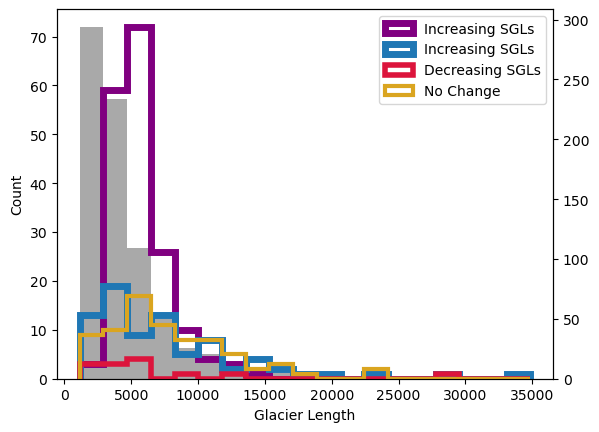

In [23]:
# histogram of length of each
fig,axs = plt.subplots()

data_point='dc_length'
d_increase = df_meta_increase[data_point]
d_decrease = df_meta_decrease[data_point]
d_nochange = df_meta_nochange[data_point]
d_nolakes = df_meta_nolakes[data_point]
d_population = df_all[data_point]
bins = np.linspace(np.nanmin(pd.concat([d_increase,d_decrease,d_nochange])),
                   np.nanmax(pd.concat([d_increase,d_decrease,d_nochange])), 20)

# twin axis showing the distribution of the entire glacier population
axs2 = axs.twinx()
axs2.hist(d_population, bins=bins, color=c_population,zorder=1)

axs.set_zorder(axs2.get_zorder() + 1)
axs.patch.set_visible(False)
axs.hist(d_nolakes, bins=bins, color=c_nolakes, histtype='step', label='No SGLs', linewidth=5,zorder=2)
axs.hist(d_increase, bins=bins, color=c_increase, histtype='step', label='Increasing SGLs', linewidth=5,zorder=2)
axs.hist(d_decrease, bins=bins, color=c_decrease, histtype='step', label='Decreasing SGLs', linewidth=4)
axs.hist(d_nochange, bins=bins, color=c_nochange, histtype='step', label='No Change', linewidth=3)

axs.legend()

axs.set_xlabel('Glacier Length')
axs.set_ylabel('Count')

Text(0, 0.5, 'Count')

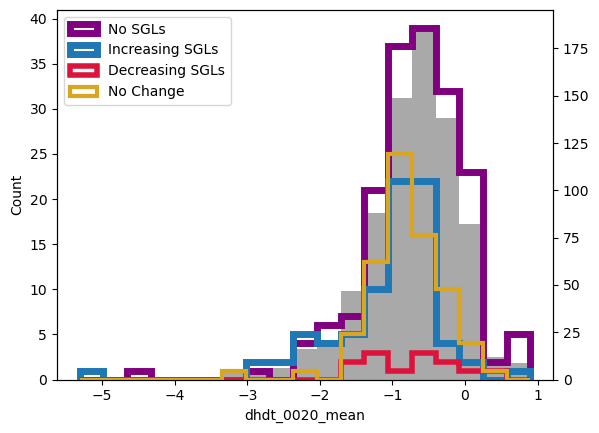

In [28]:
# histogram of dhdt of each
fig,axs = plt.subplots()

data_point='dhdt_0020_mean'
d_increase = df_meta_increase[data_point]
d_decrease = df_meta_decrease[data_point]
d_nochange = df_meta_nochange[data_point]
d_nolakes = df_meta_nolakes[data_point]
d_population = df_all[data_point]
bins = np.linspace(np.nanmin(pd.concat([d_increase,d_decrease,d_nochange])),
                   np.nanmax(pd.concat([d_increase,d_decrease,d_nochange])), 20)

# twin axis showing the distribution of the entire glacier population
axs2 = axs.twinx()
axs2.hist(d_population, bins=bins, color=c_population,zorder=1)

axs.set_zorder(axs2.get_zorder() + 1)
axs.patch.set_visible(False)
axs.hist(d_nolakes, bins=bins, color=c_nolakes, histtype='step', label='No SGLs', linewidth=5,zorder=2)
axs.hist(d_increase, bins=bins, color=c_increase, histtype='step', label='Increasing SGLs', linewidth=5,zorder=2)
axs.hist(d_decrease, bins=bins, color=c_decrease, histtype='step', label='Decreasing SGLs', linewidth=4)
axs.hist(d_nochange, bins=bins, color=c_nochange, histtype='step', label='No Change', linewidth=3)

axs.legend()

axs.set_xlabel('dhdt_0020_mean')
axs.set_ylabel('Count')

Text(0, 0.5, 'Count')

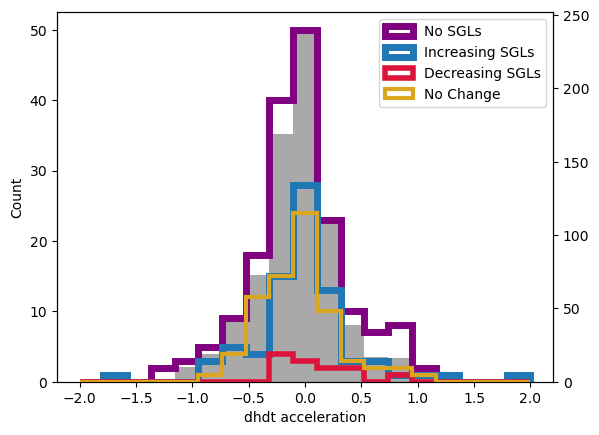

In [29]:
# histogram of dhdt 1020 minus 0010
fig,axs = plt.subplots()

d_increase = df_meta_increase['dhdt_1020_mean']-df_meta_increase['dhdt_0010_mean']
d_decrease = df_meta_decrease['dhdt_1020_mean']-df_meta_decrease['dhdt_0010_mean']
d_nochange = df_meta_nochange['dhdt_1020_mean']-df_meta_nochange['dhdt_0010_mean']
d_nolakes = df_meta_nolakes['dhdt_1020_mean']-df_meta_nolakes['dhdt_0010_mean']
d_population = df_all['dhdt_1020_mean']-df_all['dhdt_0010_mean']
bins = np.linspace(np.nanmin(pd.concat([d_increase,d_decrease,d_nochange])),
                   np.nanmax(pd.concat([d_increase,d_decrease,d_nochange])), 20)
bins = np.linspace(-2, 2, 20)

# twin axis showing the distribution of the entire glacier population
axs2 = axs.twinx()
axs2.hist(d_population, bins=bins, color=c_population,zorder=1)

axs.set_zorder(axs2.get_zorder() + 1)
axs.patch.set_visible(False)
axs.hist(d_nolakes, bins=bins, color=c_nolakes, histtype='step', label='No SGLs', linewidth=5,zorder=2)
axs.hist(d_increase, bins=bins, color=c_increase, histtype='step', label='Increasing SGLs', linewidth=5,zorder=2)
axs.hist(d_decrease, bins=bins, color=c_decrease, histtype='step', label='Decreasing SGLs', linewidth=4)
axs.hist(d_nochange, bins=bins, color=c_nochange, histtype='step', label='No Change', linewidth=3)

axs.legend()

axs.set_xlabel('dhdt acceleration')
axs.set_ylabel('Count')

Text(0, 0.5, 'Count')

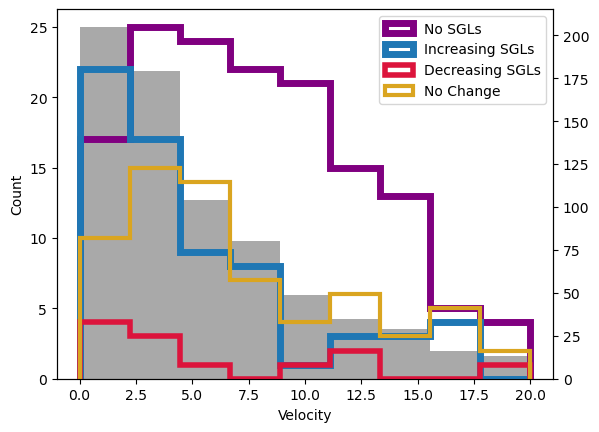

In [31]:
# histogram of velocity of each
fig,axs = plt.subplots()

data_point='v_mean'
d_increase = df_meta_increase[data_point]
d_decrease = df_meta_decrease[data_point]
d_nochange = df_meta_nochange[data_point]
d_nolakes = df_meta_nolakes[data_point]
d_population = df_all[data_point]
bins = np.linspace(0,20,10)

# twin axis showing the distribution of the entire glacier population
axs2 = axs.twinx()
axs2.hist(d_population, bins=bins, color=c_population,zorder=1)

axs.set_zorder(axs2.get_zorder() + 1)
axs.patch.set_visible(False)
axs.hist(d_nolakes, bins=bins, color=c_nolakes, histtype='step', label='No SGLs', linewidth=5,zorder=2)
axs.hist(d_increase, bins=bins, color=c_increase, histtype='step', label='Increasing SGLs', linewidth=5,zorder=2)
axs.hist(d_decrease, bins=bins, color=c_decrease, histtype='step', label='Decreasing SGLs', linewidth=4)
axs.hist(d_nochange, bins=bins, color=c_nochange, histtype='step', label='No Change', linewidth=3)

axs.legend()

axs.set_xlabel('Velocity')
axs.set_ylabel('Count')

Text(0, 0.5, 'Count')

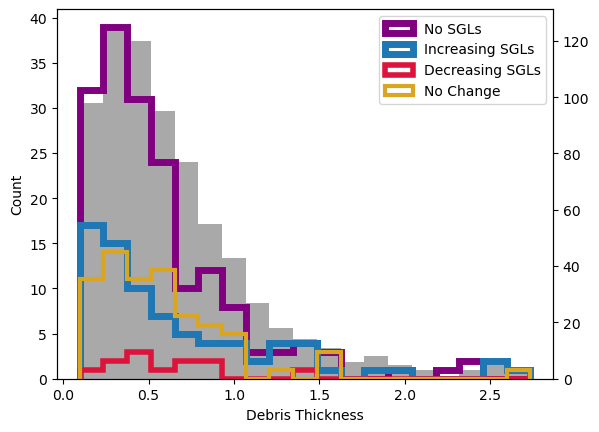

In [32]:
# histogram of length of each
fig,axs = plt.subplots()

data_point='dte_mean'
d_increase = df_meta_increase[data_point]
d_decrease = df_meta_decrease[data_point]
d_nochange = df_meta_nochange[data_point]
d_nolakes = df_meta_nolakes[data_point]
d_population = df_all[data_point]
bins = np.linspace(np.nanmin(pd.concat([d_increase,d_decrease,d_nochange])),
                   np.nanmax(pd.concat([d_increase,d_decrease,d_nochange])), 20)

# twin axis showing the distribution of the entire glacier population
axs2 = axs.twinx()
axs2.hist(d_population, bins=bins, color=c_population,zorder=1)

axs.set_zorder(axs2.get_zorder() + 1)
axs.patch.set_visible(False)
axs.hist(d_nolakes, bins=bins, color=c_nolakes, histtype='step', label='No SGLs', linewidth=5,zorder=2)
axs.hist(d_increase, bins=bins, color=c_increase, histtype='step', label='Increasing SGLs', linewidth=5,zorder=2)
axs.hist(d_decrease, bins=bins, color=c_decrease, histtype='step', label='Decreasing SGLs', linewidth=4)
axs.hist(d_nochange, bins=bins, color=c_nochange, histtype='step', label='No Change', linewidth=3)

axs.legend()

axs.set_xlabel('Debris Thickness')
axs.set_ylabel('Count')